# Paramap Analysis Using Only `groundcontrol` Core Functionality
This example does not use anything from the `.analysis` module.

In [19]:
from pathlib import Path
import typing as t
import datetime

import attr
import pandas as pd
import matplotlib as mpl
SMALLFONTSIZE = 12
MIDFONTSIZE = 16
BIGFONTSIZE = 24
def setupmpl():
    mpl.rcParams['font.size'] = MIDFONTSIZE
    mpl.rcParams['font.family'] = 'serif'
    mpl.rcParams['xtick.labelsize'] = SMALLFONTSIZE
    mpl.rcParams['ytick.labelsize'] = SMALLFONTSIZE
    mpl.rcParams['figure.figsize'] = (10, 6)
    mpl.rcParams['axes.formatter.use_mathtext'] = True
    mpl.rcParams['axes.formatter.useoffset'] = False
    mpl.rcParams['figure.dpi'] = 300
    
# this somehow doesn't get set properly with the dictionary...
setupmpl()
setupmpl()
from matplotlib import pyplot as plt
from matplotlib import ticker, cm
plt.rc('figure', figsize=(10, 6))
from IPython.display import display, Markdown
import numpy as np

from groundcontrol.declarators import quantities, declarative, parameter, quantity, setting
from groundcontrol.measurement import read_measurement_csv, MeasurementModel
from groundcontrol import units as un
from groundcontrol.util import lin2db_pow, db2lin_pow

MARKERS = ['*', '^', 'D', '>', '<', 'x']

PARAMAP_VERSION = 'v0.1'

In [2]:
Markdown(f"""
## 0. The measurement
Experiment script is `{PARAMAP_VERSION}` of `paramap.py` located in the `scripts` folder.""")


## 0. The measurement
Experiment script is `v0.1` of `paramap.py` located in the `scripts` folder.

The script must take an estimate of resonance frequency and a rough passive bandwidth.  The sweep parameters are arrays of pump frequencies and pump powers.  The pump frequencies can be conveniently given by detunings defined with the following relation:

$$
\delta' = \frac{1}{b}\left(\frac{f_p}{2} - f_r\right)
$$
where $ f_r $ is the passive resonance frequency, $ f_p $ is the pump frequency, and $ b $ is the bandwidth.
Usually the parametric amplification occurs for the values of $ \delta' $ in the range $ -3 < \delta' < 1 $ so it is convenient to use this definition.

In order to save time, the VNA is not used to sweep a lot of frequency points in a span but rather operated in zero span mode for 4 preset frequencies.  These are 2 frequency offsets given by the user and these are mirrored around 0 to obtain a total of 4 measurement frequencies.  The offset is defined with the relation $ f = f_p/2 + f_{off} $ where $ f $ is the measurement frequency.  So a measurement at the offset of 1 MHz with a pump frequency set to 10 GHz corresponds to doing a measurement at 5.001 GHz.

The exhaustive list for the parameters of the experiment is given in the following structure.  The values used in the experiment are appended, taken from the measurement script (this version of the script didn't save these).

In [3]:
@declarative
class ParaMapSettings:
    resonance_frequency: float = setting(
            nicename="Resonance Frequency",
            description="Resonance frequency (Pump off).")
    frequency_offset_1: float = setting(
            nicename="Frequency Offset 1",
            description="First frequency offset to measure gain at. "
                        "Offset is defined as `delta=fp/2-fs`.")
    frequency_offset_2: float = setting(
            nicename="Frequency Offset 2",
            description="Second frequency offset to measure gain at.")
    sample_count: int = setting(
            nicename="Sample Count",
            description="Number of samples to collect statistics from.")
    vna_power: float = setting(
            nicename="VNA Power",
            description="The output power for the VNA.")
    vna_ifbw: float = setting(
            nicename="VNA IF Bandwidth",
            description="The IF bandwidth setting for the VNA.")
    vna_navg: int = setting(
            nicename="VNA Average Count",
            description="Average count setting for the VNA.",
            default=1)
    vna_res_power: float = setting(
            nicename="Resonance VNA Power",
            description="VNA power to use when doing resonance measurement.")
    vna_res_ifbw: float = setting(
            nicename="Resonance VNA IF Bandwidth",
            description="VNA ifbw to use when doing resonance measurement.")
    vna_res_span: float = setting(
            nicename="Resonance VNA Span",
            description="VNA span to use when doing resonance measurement.")
    vna_res_sweep_step: float = setting(
            nicename="Resonance VNA Sweep Step",
            description="VNA sweep step to use when doing resonance "
                        "measurement.")
    do_cal: bool = setting(
            nicename="Perform Calibration",
            description="If enabled, the JPA is tuned to the provided "
                        "calibration bias and a transmission measurement is "
                        "performed to be used as baseline.")
    ib_cal: t.Optional[float] = setting(
            nicename="Calibration Current",
            description="Bias current to be used when calibration "
                        "is performed.  If not given, and if calibration is "
                        "enabled, bias current is set to 10 uA higher than "
                        "it's current value.")
    vna_bl_power: t.Optional[float] = setting(
            nicename="Baseline VNA Power",
            description="VNA power to be used when doing baseline "
                        "measurement.")
    vna_bl_fstart: t.Optional[float] = setting(
            nicename="Baseline VNA Start Frequency",
            description="Start frequency setting for the baseline measurement "
                        "using VNA.")
    vna_bl_fstop: t.Optional[float] = setting(
            nicename="Baseline VNA Stop Frequency",
            description="Stop frequency setting for the baseline measurement "
                        "using VNA.")

settings = ParaMapSettings(
        resonance_frequency=5.85e9,
        frequency_offset_1=1e3,
        frequency_offset_2=100e3,
        sample_count=10,
        vna_power=-30,
        vna_ifbw=50,
        vna_navg=1,
        vna_res_span=100e6,
        vna_res_ifbw=100,
        vna_res_power=-15,
        vna_res_sweep_step=1e6,
        do_cal=True,
        ib_cal=None,
        vna_bl_power=0,
        vna_bl_fstart=5.7e9,
        vna_bl_fstop=6e9
        )

The pseudocode for the experiment is as follows:

```pseudo
# resonance frequency
fr <- input
# signal power
psig <- input

# sweep parameters
sweepparams <- input
pump_frequencies  = sweepparams.fp
pump_powers = sweepparams.pp

pump.deactivate()
vna.configure(vnaset_res)
vna.set_center_frequency(f_r)
s21 = vna.measure_s21()
s21.save(mref="RES")

for fp in pump_frequencies:
    for pp in pump_powers:
        pump.set_frequency(fp)
        pump.set_power(pp)
        g1 = measure_gain(offset1)
        g2 = measure_gain(offset2)
        g1m = measure_gain(offsetmirror1)
        g2m = measure_gain(offsetmirror2)
        record = ParaMapRecord(
                fp, pp, offset1, offset2,
                g1, g2, g1m, g2m, fr, psig,
                timestamp=now())
        record.append(MREF='EXP')
        
sweepparams.save()
```

From the pseudocode, we can say the following:

    - There is a s21 measurement containing the passive resonance frequency information.
    - The gain measurements are saved as a single table with all the necessary information necessary for the setting included (fp and pp).
    - Sweep params are saved as a separate file.

## 1. Reading Data

### 1.1 Folder contents

In [6]:
DATADIR = Path("~/Measurements/BF3_JPA/200417/PARAMAP_5.85G").expanduser()
print("\n".join(map(str, DATADIR.glob('*'))))

/home/ckutlu/Measurements/BF3_JPA/200417/PARAMAP_5.85G/groundcontrol.log
/home/ckutlu/Measurements/BF3_JPA/200417/PARAMAP_5.85G/measurements.index
/home/ckutlu/Measurements/BF3_JPA/200417/PARAMAP_5.85G/paramap.py
/home/ckutlu/Measurements/BF3_JPA/200417/PARAMAP_5.85G/PMR
/home/ckutlu/Measurements/BF3_JPA/200417/PARAMAP_5.85G/PMSP
/home/ckutlu/Measurements/BF3_JPA/200417/PARAMAP_5.85G/SPPM


In [7]:
LOGFILE = DATADIR / "groundcontrol.log"
INDEXFILE = DATADIR / "measurements.index"
MEASUREMENT_SCRIPT = DATADIR / "paramap.py"
PMRDIR = DATADIR / "PMR"
PMSPDIR = DATADIR / "PMSP"
SPPMDIR = DATADIR / "SPPM"

print(f"Contents at {PMRDIR}")
print("\t{}".format("\n\t".join(map(str, PMRDIR.glob('*')))))
print(f"Contents at {PMSPDIR}")
print("\t{}".format("\n\t".join(map(str, PMSPDIR.glob('*')))))
print(f"Contents at {SPPMDIR}")
print("\t{}".format("\n\t".join(map(str, SPPMDIR.glob('*')))))

Contents at /home/ckutlu/Measurements/BF3_JPA/200417/PARAMAP_5.85G/PMR
	/home/ckutlu/Measurements/BF3_JPA/200417/PARAMAP_5.85G/PMR/PMR-AP_EXP_2.csv
Contents at /home/ckutlu/Measurements/BF3_JPA/200417/PARAMAP_5.85G/PMSP
	/home/ckutlu/Measurements/BF3_JPA/200417/PARAMAP_5.85G/PMSP/PMSP_NOREF_0.csv
Contents at /home/ckutlu/Measurements/BF3_JPA/200417/PARAMAP_5.85G/SPPM
	/home/ckutlu/Measurements/BF3_JPA/200417/PARAMAP_5.85G/SPPM/SPPM_RES_1.csv


The standard name for csv files in `groundcontrol` is "`<MCLASS>_<MREF>_<INDEX>.csv`".  When a measurement is appended into each other, the `MCLASS` gets a `"-AP"` suffix by default.  `MCLASS` is the name of the class that is used to hold the data of the measurement.  It's always derived from `groundcontrol.measurement.MeasurementModel`.

### 1.2 Measurement Index
The measurement index contains all the recorded measurement results, corresponding indexes and timestamps.  Let's read it into a pandas dataframe.

First checking the contents.

In [8]:
with open(INDEXFILE) as ifl:
    nline = 3
    for i in range(nline):
        print(ifl.readline().strip())

0, 2020-04-17 17:41:14.562962, ParaMapSweepParameters, PMSP/PMSP_NOREF_0.csv
1, 2020-04-17 17:41:23.618523, SParam1PModel, SPPM/SPPM_RES_1.csv
2, 2020-04-17 17:41:24.738917, ParaMapRecord, PMR/PMR-AP_EXP_2.csv


The columns are labeled as follows:

In [9]:
colnames = ['index', 'timestamp', 'mclass', 'datapath']

Converting functions that converts string from the file to the final datatype of the column

In [10]:
converters = dict(zip(colnames, [int, datetime.datetime.fromisoformat, str, Path]))

Creating the pandas dataframe

In [11]:
df = pd.read_csv(INDEXFILE, index_col=0, names=colnames, converters=converters, skipinitialspace=True)
display(df)

timestamp                  mclass  \
index                                                      
0     2020-04-17 17:41:14.562962  ParaMapSweepParameters   
1     2020-04-17 17:41:23.618523           SParam1PModel   
2     2020-04-17 17:41:24.738917           ParaMapRecord   
3     2020-04-17 17:41:25.784696           ParaMapRecord   
4     2020-04-17 17:41:26.813524           ParaMapRecord   
...                          ...                     ...   
14388 2020-04-17 21:40:13.995151           ParaMapRecord   
14389 2020-04-17 21:40:14.991781           ParaMapRecord   
14390 2020-04-17 21:40:15.974412           ParaMapRecord   
14391 2020-04-17 21:40:16.957470           ParaMapRecord   
14392 2020-04-17 21:40:17.941041           ParaMapRecord   

                    datapath  
index                         
0      PMSP/PMSP_NOREF_0.csv  
1        SPPM/SPPM_RES_1.csv  
2       PMR/PMR-AP_EXP_2.csv  
3       PMR/PMR-AP_EXP_2.csv  
4       PMR/PMR-AP_EXP_2.csv  
...                      ...  
14388   PMR/PMR-AP_EXP_2.csv  
14389   PMR/PMR-AP_EXP_2.csv  
14390   PMR/PMR-AP_EXP_2.csv  
14391   PMR/PMR-AP_EXP_2.csv  
14392   PMR/PMR-AP_EXP_2.csv  

[14393 rows x 3 columns]

### 1.3 Investigating data content

Let's check what "unique" measurement types we have:

In [12]:
print(df.mclass.unique())

['ParaMapSweepParameters' 'SParam1PModel' 'ParaMapRecord']


We can also check how many unique datapaths we have.  Most of the experiment scripts create data file per measurement, however sometimes measurements are appended to a single file in which case the filename will have the form "`<MCLASS>-AP_<MREF>_<INDEX>`" instead

In [13]:
uniqpaths =list(df.datapath.unique()) 
print(list(map(str, uniqpaths)))

['PMSP/PMSP_NOREF_0.csv', 'SPPM/SPPM_RES_1.csv', 'PMR/PMR-AP_EXP_2.csv']


In [14]:
# ParaMapSweepParamaters - PMSP
pmspfile = DATADIR / uniqpaths[0]
sppmfile = DATADIR / uniqpaths[1]
pmrfile = DATADIR / uniqpaths[2]

### 1.4 Reading the data into DataFrame
We know that all the relevant data is contained within PMR type of measurement.  Let's check first few lines of the file:

In [15]:
with open(pmrfile) as pmrfl:
    nline = 7
    for i in range(nline):
        print(pmrfl.readline().strip())

# MCLASS=ParaMapRecord-AP
# MREF=EXP
# ResonanceFrequency=5850000000.0 Hz
# SignalPower=-30 dBm
# Timestamp=2020-04-17 17:41:24.738917
# index, PumpFrequency[Hz], PumpPower[dBm], FrequencyOffset1[Hz], FrequencyOffset2[Hz], Gain@F1[dB], Gain@F2[dB], Gain@F1m[dB], Gain@F2m[dB]
2.000000000000000000e+00,1.166800000000000000e+10,-1.000000000000000000e+01,1.000000000000000000e+03,1.000000000000000000e+05,-3.054634854577017222e+00,-1.372483709856169298e+00,-8.003988371073447183e-01,-8.715540345072838591e-01


We can simply read this as table in a pandas DataFrame.

In [16]:
mdata = pd.read_csv(
    pmrfile,
    names='index fp pp fo1 fo2 g1 g2 g1m g2m'.split(),
    index_col=0,
    dtype={'index': int},
    skipinitialspace=True,
    comment='#',
)

display(mdata)

fp    pp     fo1       fo2        g1        g2       g1m  \
index                                                                       
2      1.166800e+10 -10.0  1000.0  100000.0 -3.054635 -1.372484 -0.800399   
3      1.166800e+10  -9.9  1000.0  100000.0 -0.109709 -1.175430 -0.415078   
4      1.166800e+10  -9.8  1000.0  100000.0 -0.819849  0.930059 -2.616704   
5      1.166800e+10  -9.7  1000.0  100000.0  0.228218 -0.500687  0.028739   
6      1.166800e+10  -9.6  1000.0  100000.0  0.549660 -1.952771 -0.161753   
...             ...   ...     ...       ...       ...       ...       ...   
14388  1.173200e+10  24.6  1000.0  100000.0  0.554423  1.906226  1.992740   
14389  1.173200e+10  24.7  1000.0  100000.0  1.607196  1.276421  0.777444   
14390  1.173200e+10  24.8  1000.0  100000.0  1.169079  2.807183  1.324513   
14391  1.173200e+10  24.9  1000.0  100000.0 -0.306584  1.206162  1.984879   
14392  1.173200e+10  25.0  1000.0  100000.0  1.674024  0.890748  1.210710   

            g2m  
index            
2     -0.871554  
3      0.974902  
4     -1.636107  
5     -1.104287  
6     -0.969908  
...         ...  
14388  2.096092  
14389  0.844740  
14390  1.843669  
14391  2.587872  
14392  2.253688  

[14391 rows x 8 columns]

### 1.5 (NOT FINISHED) Reading the data into proper MeasurementModel

In order to read it we can write a simple data structure that describes the data in the csv and the reading functionality will be automatically generated.

To understand what I mean, let's check the first few lines of the raw file:

In [62]:
with open(pmrfile) as pmrfl:
    nline = 10
    for i in range(nline):
        print(pmrfl.readline().strip())

# MCLASS=ParaMapRecord-AP
# MREF=EXP
# ResonanceFrequency=5850000000.0 Hz
# SignalPower=-30 dBm
# Timestamp=2020-04-17 17:41:24.738917
# index, PumpFrequency[Hz], PumpPower[dBm], FrequencyOffset1[Hz], FrequencyOffset2[Hz], Gain@F1[dB], Gain@F2[dB], Gain@F1m[dB], Gain@F2m[dB]
2.000000000000000000e+00,1.166800000000000000e+10,-1.000000000000000000e+01,1.000000000000000000e+03,1.000000000000000000e+05,-3.054634854577017222e+00,-1.372483709856169298e+00,-8.003988371073447183e-01,-8.715540345072838591e-01
3.000000000000000000e+00,1.166800000000000000e+10,-9.900000000000000355e+00,1.000000000000000000e+03,1.000000000000000000e+05,-1.097088586271581789e-01,-1.175430265185994472e+00,-4.150782810547681834e-01,9.749022924164236770e-01
4.000000000000000000e+00,1.166800000000000000e+10,-9.800000000000000711e+00,1.000000000000000000e+03,1.000000000000000000e+05,-8.198486140008185430e-01,9.300586204291221293e-01,-2.616703720815401368e+00,-1.636107375589446633e+00
5.000000000000000000e+00,1.166800000

Based on what we see, we can use the following model to read the data.  Currently, the units are not checked by default when reading a file.  So you will not get an error if you give different units in the structure.  Now it is important to note that the MCLASS having the '-AP' suffix is special.  MCLASS is a string referring to a class used to hold the data.  Python doesn't allow '-' to be used in class names to `ParaMapRecord-AP` is not an acceptable class name.  The '-AP' suffix is to denote that this file is a composition of ParaMapRecords.  This functionality is not widely used in other scripts yet, and may be deprecated in the future.

In [58]:
class ParaMapRecord(MeasurementModel):
    fp: float = quantity(un.hertz, "PumpFrequency")
    pp: float = quantity(un.dBm, "PumpPower")
    fo1: float = quantity(un.hertz, "FrequencyOffset1")
    fo2: float = quantity(un.hertz, "FrequencyOffset2")
    g1: float = quantity(un.dB, "Gain@F1")
    g2: float = quantity(un.dB, "Gain@F2")
    g1m: float = quantity(
            un.dB, "Gain@F1m", description="Gain at mirror frequency of f1")
    g2m: float = quantity(
            un.dB, "Gain@F2m", description="Gain at mirror frequency of f2")

    fr: float = parameter(un.hertz, "ResonanceFrequency")
    ps: float = parameter(un.dBm, "SignalPower")
    timestamp: datetime.datetime = parameter(
            un.nounit, "Timestamp",
            default=attr.Factory(datetime.datetime.now))

Because the MCLASS contains the '-AP' suffix, the measurement reader treats the file specially and reads the index column separately and appends it to the datastructure.  It does not appear in the usual data array, but can be reached via the `.index` attribute.

In [60]:
pmrmeas = read_measurement_csv(pmrfile)
len(pmrmeas.fp)

print("SOME PROBLEM HERE")

8

## 2. Plotting
Let's do a quick plot using the pandas dataframe.

Pump frequencies (min, max, npoints):
11668000000.0 11732000000.0 41
Delta frequencies (min, max, npoints):
-16.0 16.0 41
Pump powers (min, max, npoints):
-10.0 24.999999999999872 351


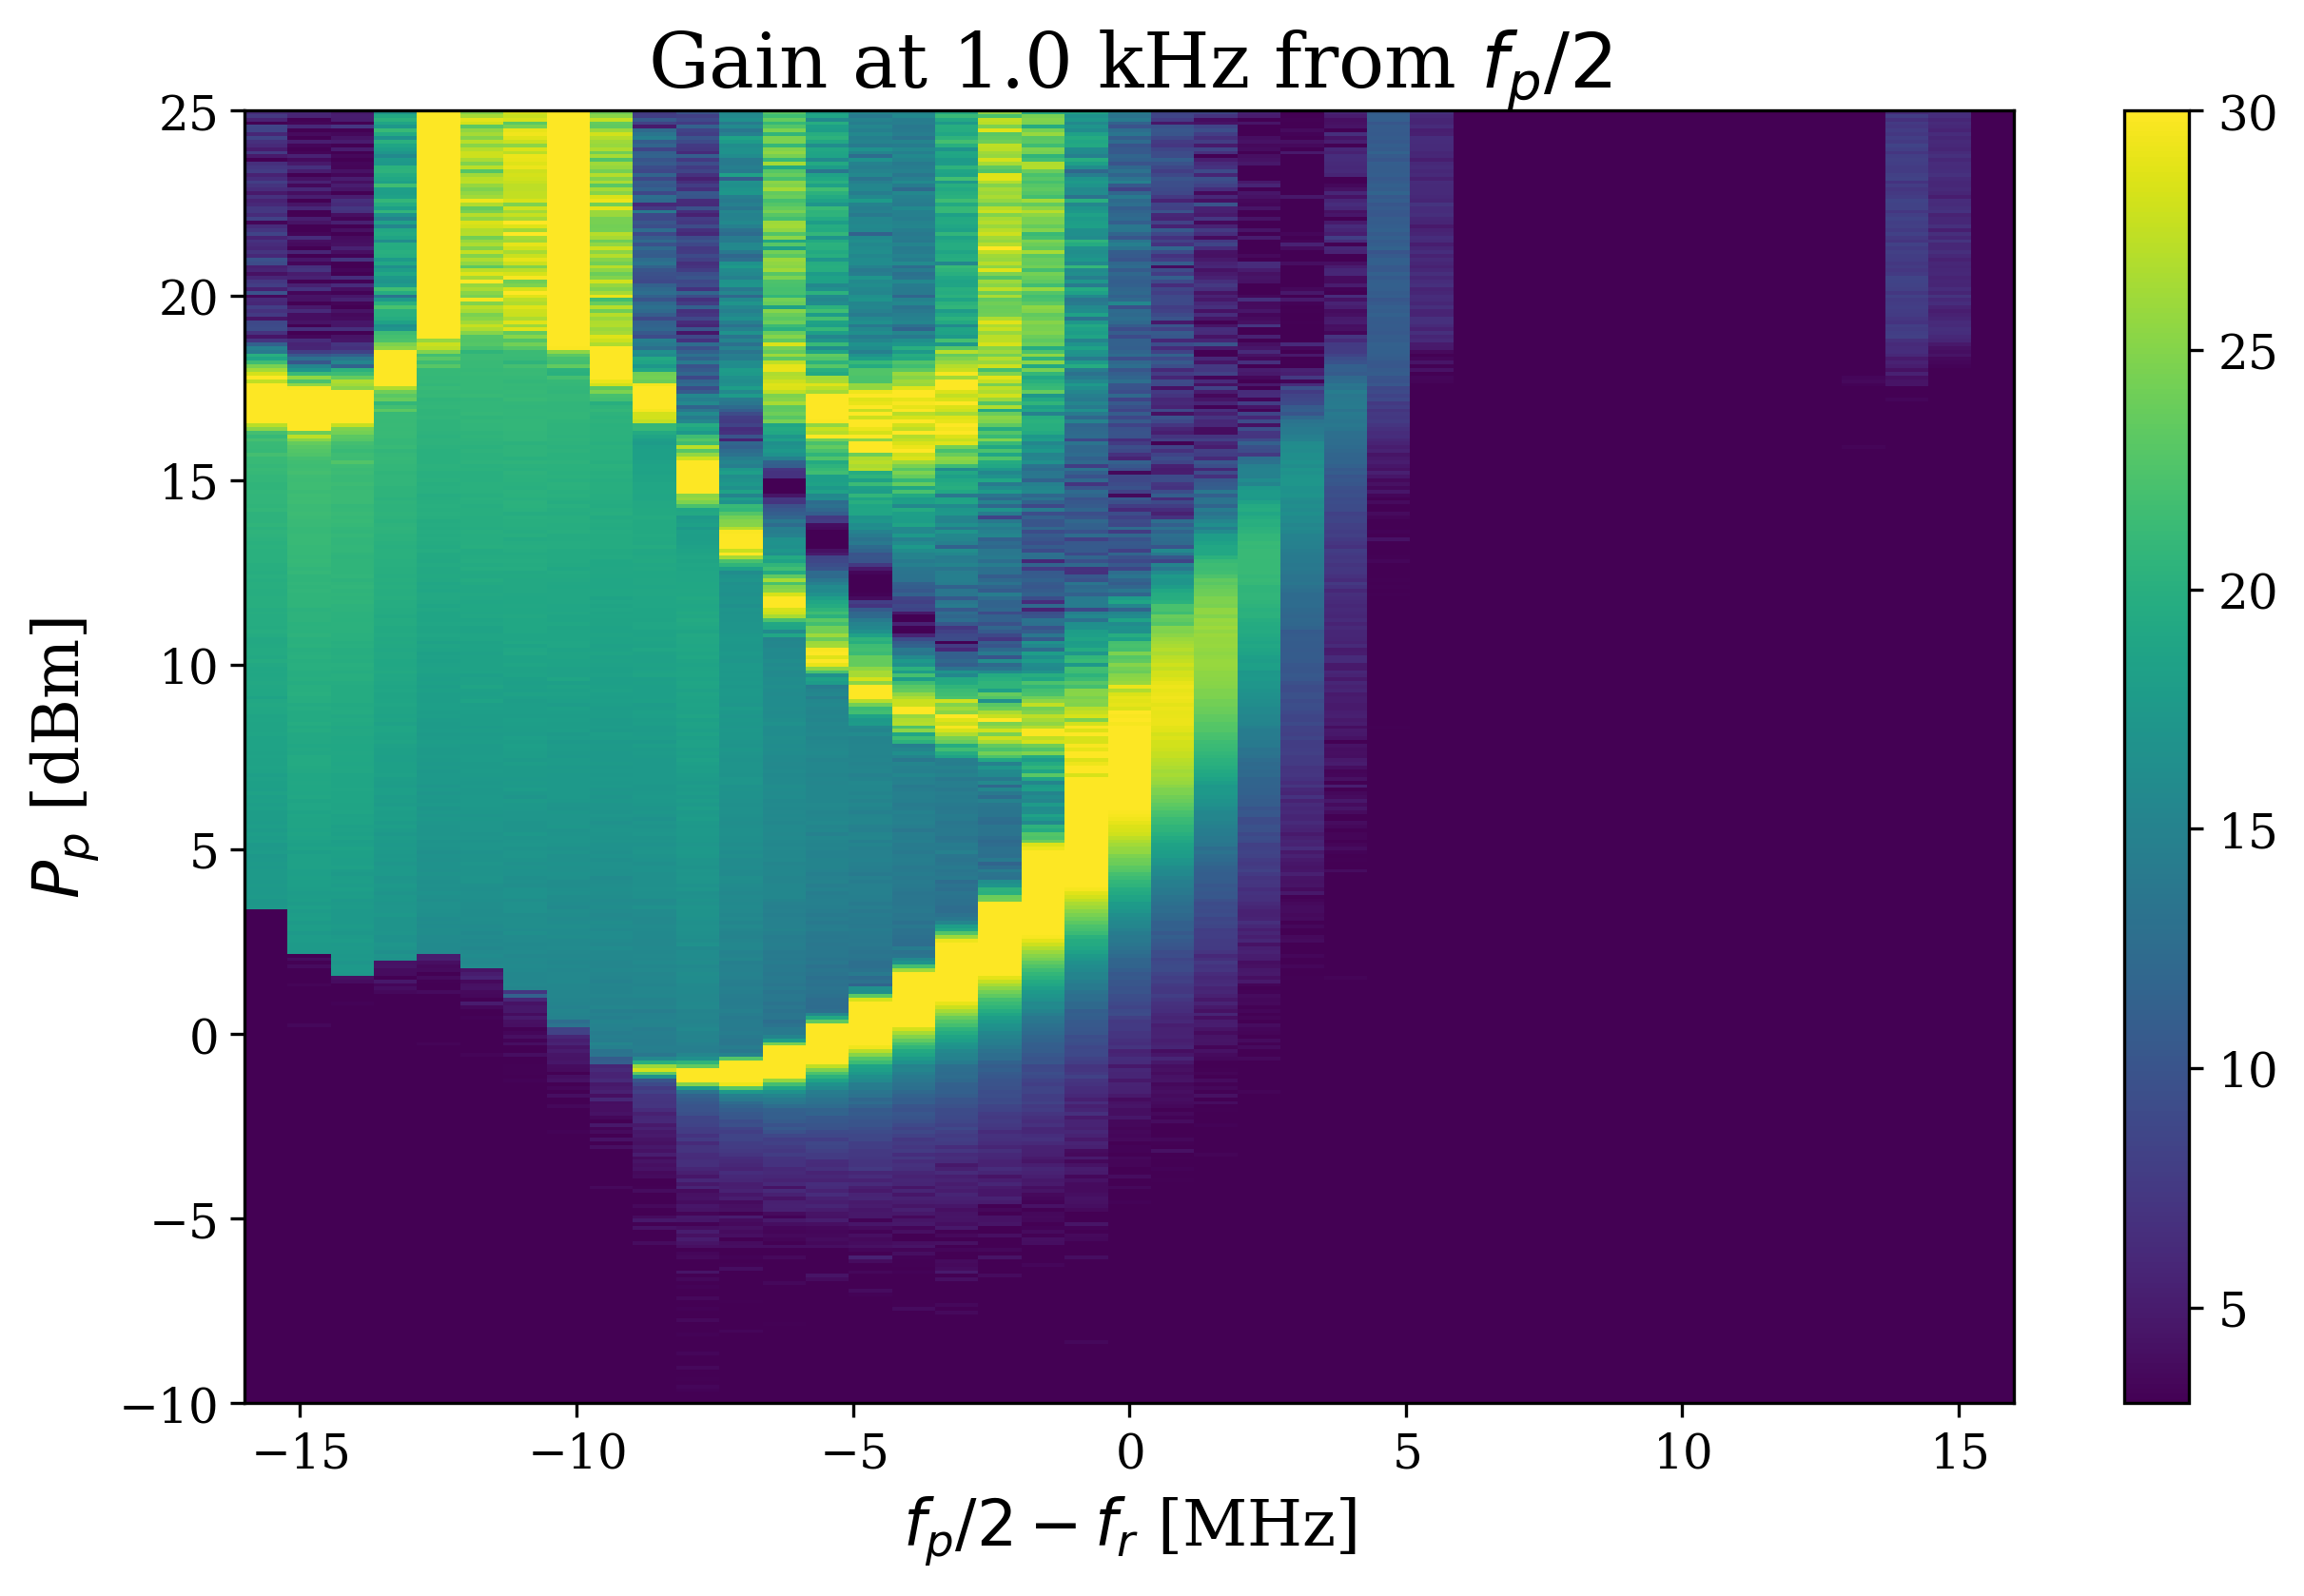

In [67]:
from scipy import ndimage

fr = settings.resonance_frequency

fpuniq = mdata.fp.unique()
delta_MHz = (fpuniq/2 - fr)/1e6
ppuniq = mdata.pp.unique()
print("Pump frequencies (min, max, npoints):")
print(fpuniq.min(), fpuniq.max(), len(fpuniq))
print("Delta frequencies (min, max, npoints):")
print(delta_MHz.min(), delta_MHz.max(), len(delta_MHz))
print("Pump powers (min, max, npoints):")
print(ppuniq.min(), ppuniq.max(), len(ppuniq))
shape = (len(fpuniq), len(ppuniq))
#shape = (len(ppuniq), len(fpuniq))

#print(f"Shape of the grid: {shape}")

plotdata = 'g1'
foffset_khz = settings.frequency_offset_1/1e3

data_arr = mdata[plotdata].array
data_matrix = np.reshape(data_arr, shape)

fig, ax = plt.subplots(figsize=(10,6))
#cs = ax.contourf(fpgrid, ppgrid, data, cmap=cm.PuBu_r)
im = ax.imshow(
    data_matrix.T, vmin=3, vmax=30, aspect='auto', origin='lower',
    extent=(delta_MHz.min(), delta_MHz.max(), ppuniq.min(), ppuniq.max())
    )
# , locator=ticker.LogLocator()
ax.set_xlabel("$f_p/2 - f_r$ [MHz]")
ax.set_ylabel("$ P_p $ [dBm]")
ax.set_title(f"Gain at {foffset_khz} kHz from $f_p/2$")
fig.colorbar(im)

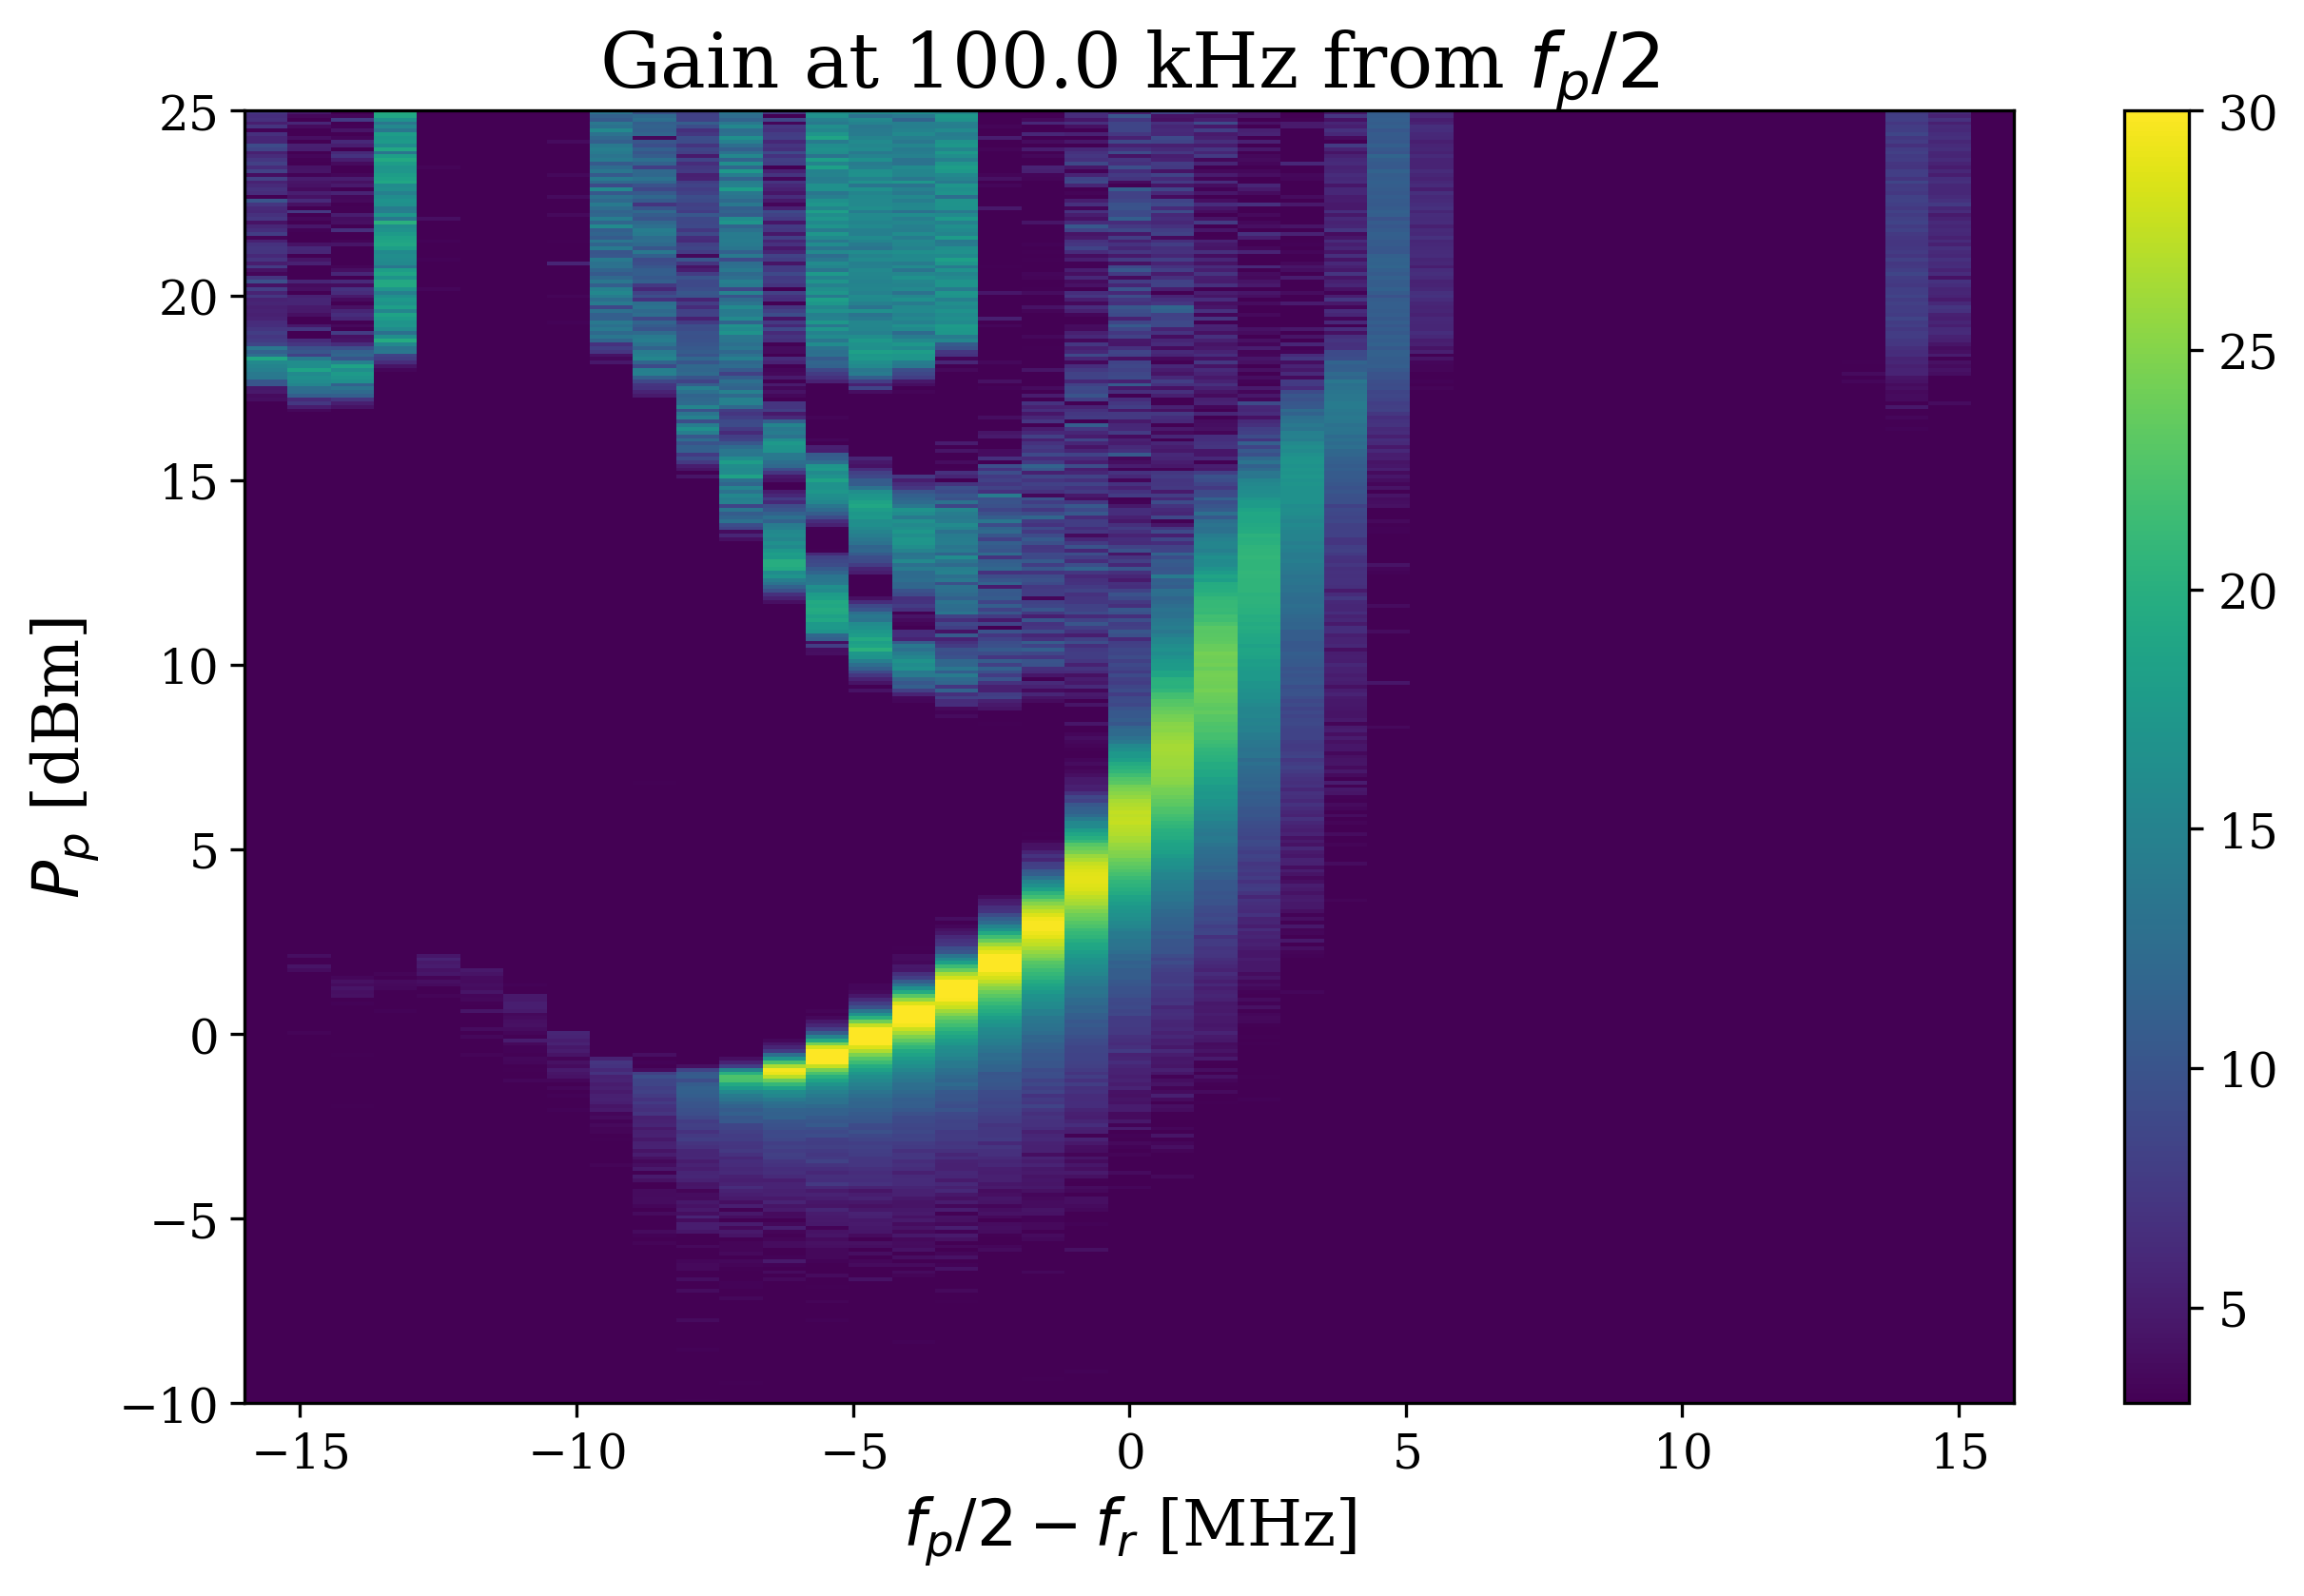

In [68]:
plotdata = 'g2'
foffset_khz = settings.frequency_offset_2/1e3
data_arr = mdata[plotdata].array
data_matrix = np.reshape(data_arr, shape)

fig, ax = plt.subplots(figsize=(10,6))
#cs = ax.contourf(fpgrid, ppgrid, data, cmap=cm.PuBu_r)
im = ax.imshow(
    data_matrix.T, vmin=3, vmax=30, aspect='auto', origin='lower',
    extent=(delta_MHz.min(), delta_MHz.max(), ppuniq.min(), ppuniq.max())
    )
# , locator=ticker.LogLocator()
ax.set_xlabel("$f_p/2 - f_r$ [MHz]")
ax.set_ylabel("$ P_p $ [dBm]")
ax.set_title(f"Gain at {foffset_khz} kHz from $f_p/2$")
fig.colorbar(im)

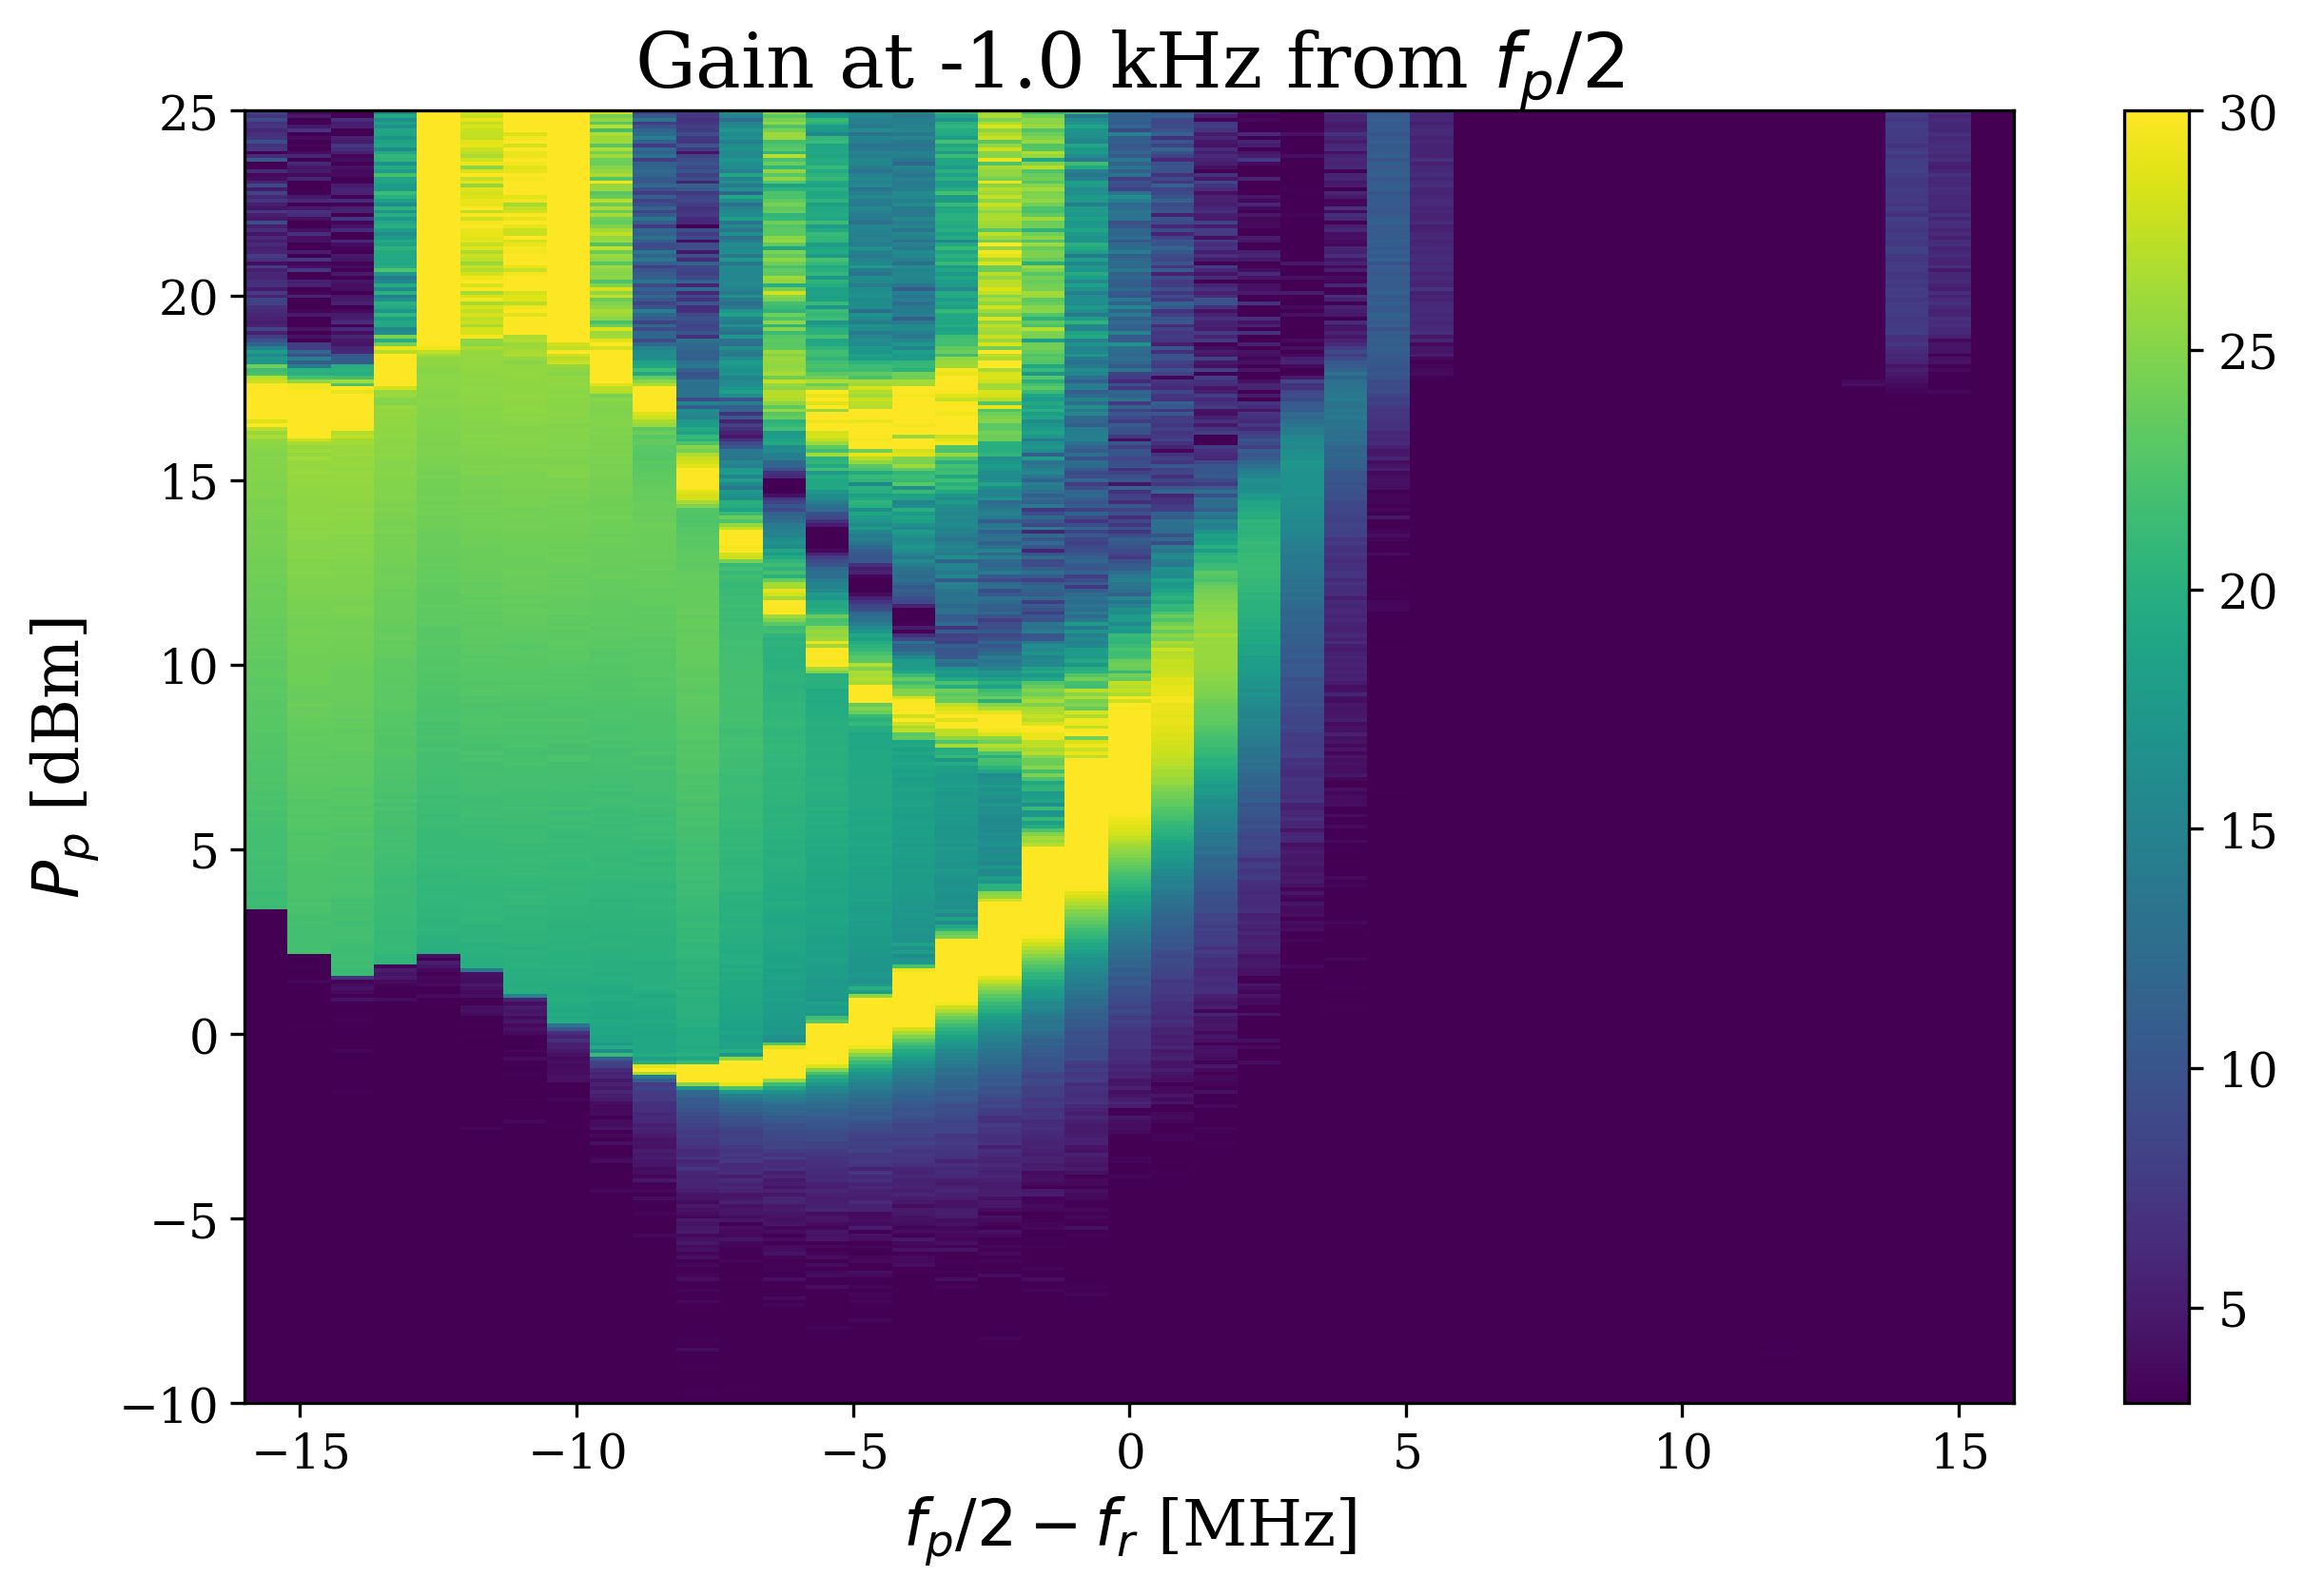

In [69]:
plotdata = 'g1m'
foffset_khz = -settings.frequency_offset_1/1e3
data_arr = mdata[plotdata].array
data_matrix = np.reshape(data_arr, shape)

fig, ax = plt.subplots(figsize=(10,6))
#cs = ax.contourf(fpgrid, ppgrid, data, cmap=cm.PuBu_r)
im = ax.imshow(
    data_matrix.T, vmin=3, vmax=30, aspect='auto', origin='lower',
    extent=(delta_MHz.min(), delta_MHz.max(), ppuniq.min(), ppuniq.max())
    )
# , locator=ticker.LogLocator()
ax.set_xlabel("$f_p/2 - f_r$ [MHz]")
ax.set_ylabel("$ P_p $ [dBm]")
ax.set_title(f"Gain at {foffset_khz} kHz from $f_p/2$")
fig.colorbar(im)

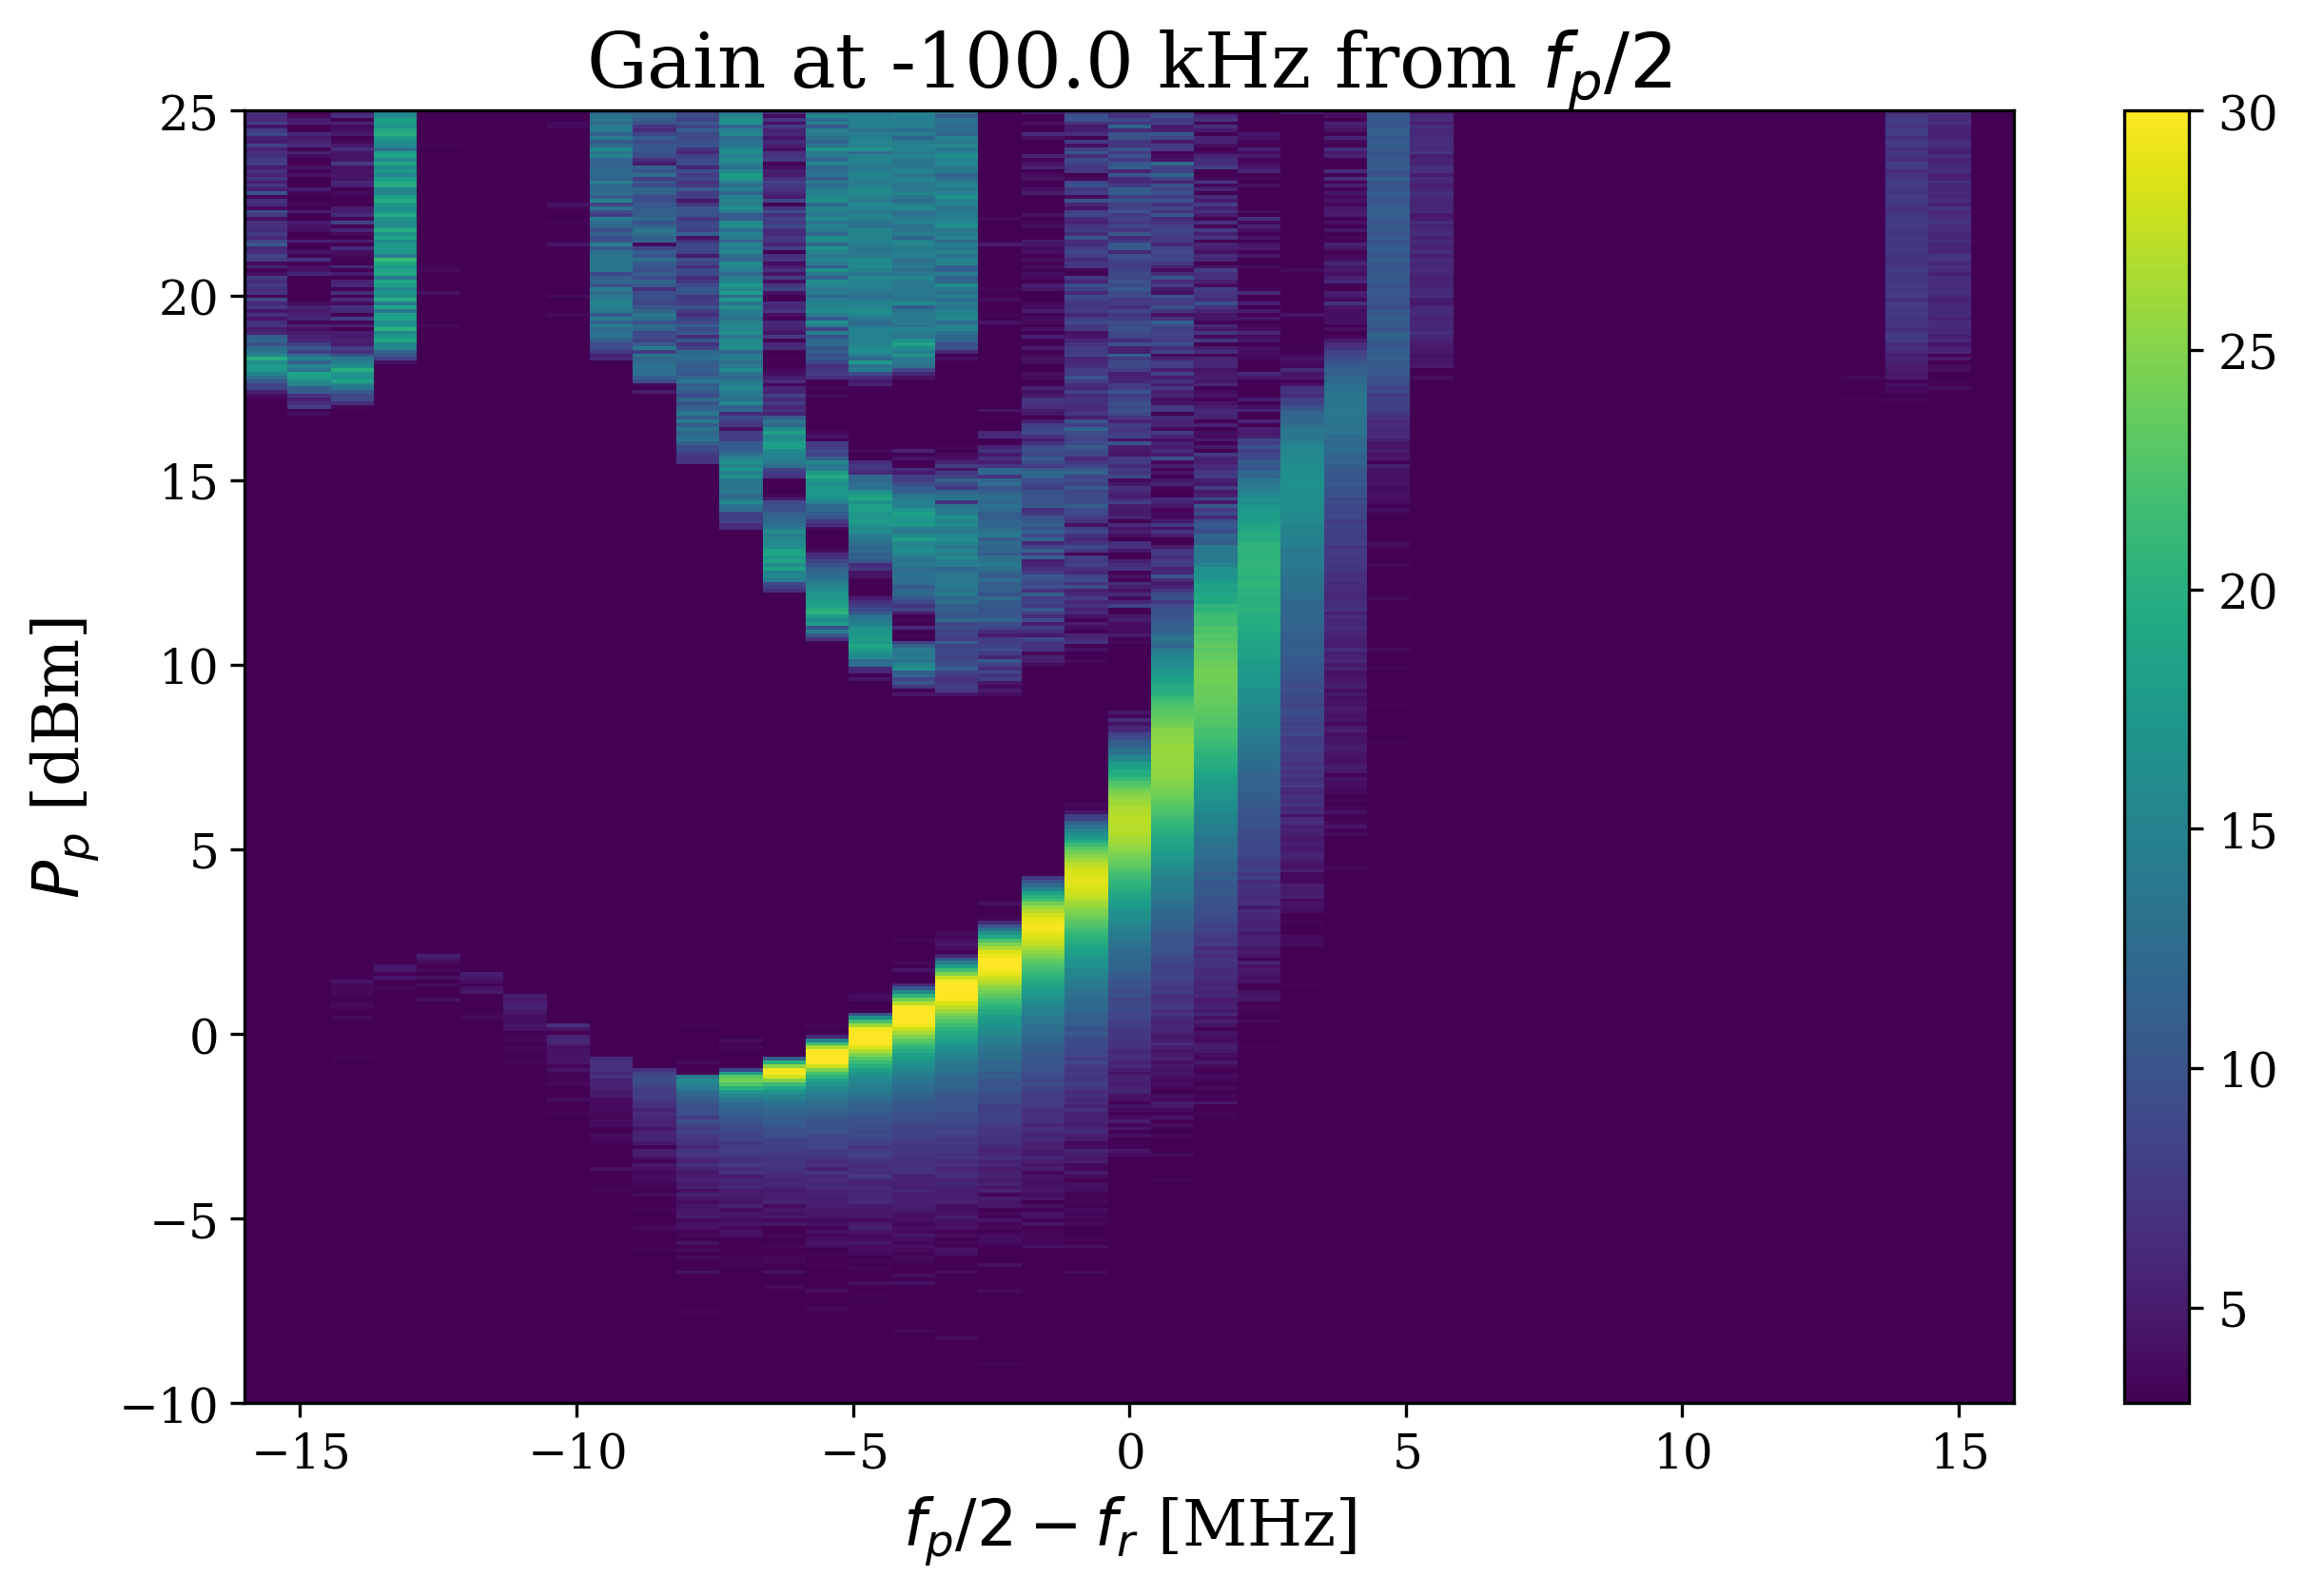

In [70]:
plotdata = 'g2m'
foffset_khz = -settings.frequency_offset_2/1e3
data_arr = mdata[plotdata].array
data_matrix = np.reshape(data_arr, shape)

fig, ax = plt.subplots(figsize=(10,6))
#cs = ax.contourf(fpgrid, ppgrid, data, cmap=cm.PuBu_r)
im = ax.imshow(
    data_matrix.T, vmin=3, vmax=30, aspect='auto', origin='lower',
    extent=(delta_MHz.min(), delta_MHz.max(), ppuniq.min(), ppuniq.max())
    )
# , locator=ticker.LogLocator()
ax.set_xlabel("$f_p/2 - f_r$ [MHz]")
ax.set_ylabel("$ P_p $ [dBm]")
ax.set_title(f"Gain at {foffset_khz} kHz from $f_p/2$")
fig.colorbar(im)